# Coursera, SDC-ND, Term 1, P4

Advanced Lane Finding Project

Comments are in the readme-file

## Setup

In [1]:
# Step 1.1: Paths 

In [2]:
# Windows:
#path_folder = '...'

#Ubuntu:
path_folder = '/home/mk/Desktop/T1/P4/'

# Paths on both laptops:
path_folder_projectvideo = path_folder + 'project_video.mp4'
#path_folder_projectvideo_res = path_folder + 'project_video_result.mp4'
path_folder_projectvideo_res = 'project_video_result.mp4'

path_calibration = path_folder + 'camera_cal/'
path_calibration_files = path_calibration + 'calibration*.jpg'
path_calibration_1 = path_calibration + 'calibration1.jpg'
path_calibration_1_undist = path_calibration + 'calibration1_undist.jpg'

path_test = path_folder + 'test_images/'
test_image_1 = 'test1.jpg'
test_image_2 = 'test2.jpg'
test_image_3 = 'test3.jpg'
test_image_4 = 'test4.jpg'
test_image_5 = 'test5.jpg'
test_image_6 = 'test6.jpg'

# Path for test images output:
path_test_output = path_folder + 'output_images/'

In [3]:
# Step 1.2: Imports

In [4]:
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Calibration

In [5]:
# Step 2: Calibration files
imgs = glob.glob( path_calibration_files )

In [6]:
# Step 3: Calibration arrays 
chessboard_vertical = 9
chessboard_horizontal = 6
arr_2d_pts = []
arr_3d_pts = [] 
arr_pts = np.zeros((chessboard_horizontal*chessboard_vertical,3), np.float32)
arr_pts[:,:2] = np.mgrid[0:chessboard_vertical,0:chessboard_horizontal].T.reshape(-1,2)

In [7]:
# Step 4: grayscale and identify chessboard corners:
for fname in imgs:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_vertical,chessboard_horizontal),None)
    # If found, add object points, image points
    if ret == True:
        arr_3d_pts.append(arr_pts)
        arr_2d_pts.append(corners)
        img = cv2.drawChessboardCorners(img, (chessboard_vertical,chessboard_horizontal), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(25) 

In [8]:
# Step 5: Compute camera calibration: 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(arr_3d_pts, arr_2d_pts, gray.shape[::-1],None,None)

In [9]:
# Step 6: Distortion 
img = cv2.imread( path_calibration_1 )
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite( path_calibration_1_undist, dst )

True

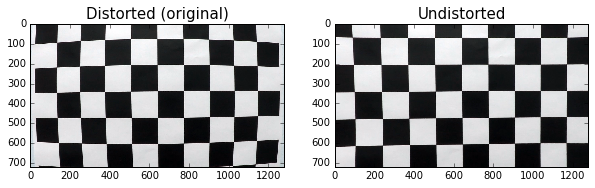

In [10]:
# Step 7: Visualize distortion:
f, (img_viz1, img_viz2) = plt.subplots(1, 2, figsize=(10,10))
img_viz1.imshow(img)
img_viz1.set_title('Distorted (original)', fontsize=15)
img_viz2.imshow(dst)
img_viz2.set_title('Undistorted', fontsize=15)

In [11]:
cv2.destroyAllWindows()

## Lanes, pipeline, test:

In [12]:
# Step 8: lanes, pipeline, test:

In [13]:
class LaneObj():
    def __init__(self):
        self.x_arr = None 
        self.y_arr = None
        self.xf = []
        self.lane_y = None   
        self.lane_x = None  
        self.x_bst = None     
        self.fit_bst = None   
        self.fit = [np.array([False])] 
        self.delta = np.array([0,0,0], dtype='float')

In [14]:
def new_l(nzx1, nzy1, start, stop, w, f):
    if len(f) == 3:
        f_x = f[0]*nzy1**2 + f[1]*nzy1 + f[2]
    elif len(f) == 2:
        f_x = f[0]*nzy1 + f[1] 
    result = ((nzx1 >= (f_x - w)) \
                    & (nzx1 <= (f_x + w)) \
                    & (nzy1 > start) \
                    & (nzy1 <= stop)).nonzero()[0]
    return result

In [15]:
def getLane(x1, y1, arr_pixel, ysf, start, shape, m):
    
    # Identify start of lane 
    ysf_new = ysf - 0.1
    ns = 1 + ysf_new/0.1
    ystarts = np.linspace(ysf_new, 0, ns, endpoint=True)
    dy = 1 - 0 
    help1 = ((x1 >= arr_pixel[0]) & (x1 <= arr_pixel[1]) & (y1 >= start)).nonzero()[0]
    
    for ys in ystarts: 
        
        # fit line:
        start = round(shape[0]*ys)   
        stop = round(shape[0]*(ys+dy))
        order = 1 # polynomial order        
        line1 = np.polyfit(y1[help1], x1[help1] , order) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        
        #add additional pixel line:
        help2 = new_l(x1, y1, start, stop, m, line1)  
        min_pixel = 0
        if len(help2) > min_pixel: 
            help1 = np.hstack((help1, help2))    
    
    return np.unique(help1)

In [16]:
def saveTestWarp( input_path, output_path ):
    
    img = mpimg.imread( input_path )
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = (img.shape[1], img.shape[0])
    #print('img_size: ', img_size)
    #print('img.shape[1]: ', img.shape[1])
    #print('img.shape[0]: ', img.shape[0])
    
    src = np.float32(
        [[585, 460],
         [203, 720],
         [1127, 720],
         [ 695, 460]])
    dst = np.float32(
        [[320, 0],
         [320, 720],
         [960, 720],
         [960, 0]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    source_image_warp = cv2.warpPerspective(img, M, img_size)
   
    #cv2.imshow('imageSaveTestWarp',source_image_warp)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    cv2.imwrite( output_path , source_image_warp ) 
       

In [17]:
def getWarp( bin_red, bin_s, projB ):
    
    # 3. gray and red in binary image
    bin_red_image = np.clip(cv2.bitwise_or(bin_red, bin_s), 0, 1).astype('uint8')

    # 4. transform and warp perspective, image and zero-copies for projections:
    bin_red_shapeT = (bin_red.shape[1], bin_red.shape[0])
    #print('bin_red_shapeT: ', bin_red_shapeT)
    #print('bin_red.shape[1]: ', bin_red.shape[1])
    #print('bin_red.shape[0]: ', bin_red.shape[0])
    
    size_1 = np.float32(
        [[585, 460],
         [203, 720],
         [1127, 720],
         [ 695, 460]])
    
    warp_dst = np.float32(
        [[320, 0],
         [320, 720],
         [960, 720],
         [960, 0]])

    source_image_warp = cv2.warpPerspective(bin_red_image, cv2.getPerspectiveTransform(size_1, warp_dst), bin_red_shapeT, flags=cv2.INTER_NEAREST) 
    #source_image_warpB = cv2.warpPerspective(projB, cv2.getPerspectiveTransform(size_1, warp_dst), bin_red_shapeT, flags=cv2.INTER_NEAREST) 
    
    #cv2.imshow('image',source_image_warp)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    #cv2.imshow('image',source_image_warpB)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    return source_image_warp, size_1, warp_dst

In [18]:
def getImageWithProjectionAndText( source_image ):

    bottom = 719.
    vertical_center = 430 #418
    left_horizontal_start = 170
    left_horizontal_stop = 600
    right_horizontal_start = 720#700 #620
    right_horizontal_stop = 1200#1279
    dict_ = { 'coords': np.array( [ [ (left_horizontal_start,bottom), (left_horizontal_stop,vertical_center), (right_horizontal_start,vertical_center), (right_horizontal_stop,bottom) ] ], dtype = np.int32 ) }
    
    source_image_shape = source_image.shape
    center = source_image_shape[1]/2
    horizontal_factor = 0.6*1280*2.5 #1280 pixel * 0.6 because lane is approx. 60% of screen at bottom * 2.5 because lane is approx. 2.5 wide
    distance_factor = 300/15 #approx 300 pixel distance / distance in meter
    smth1 = 8 
    ysf = 0.3 
    m = 41 
    lane_min_pixels = 13 
    smth = 6  
    det = 7 
    lane_r = LaneObj()
    lane_l = LaneObj()    
    
    # 1. Undistort 
    dst = cv2.undistort(source_image, mtx, dist, None, mtx)
    
    #cv2.imshow('image1',dst)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    #saveTestWarp( dst, path_test_output )
   

    # 2. Grayscale and Sobel
    # http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html
    graycolor = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    
    #cv2.imshow('image2',graycolor)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
   

    abss_x = np.absolute( cv2.Sobel(graycolor, cv2.CV_64F, 1, 0) ) 
    computation_helper_1 = np.max(abss_x)/255 
    abss_x = ( abss_x / computation_helper_1 ).astype(np.uint8)
    # Initialization of blank proj
    proj = np.zeros(abss_x.shape, np.float) 
    if len(abss_x.shape) > 2:
        proj_color_keep = (255,)*abss_x.shape[2]
    else:
        proj_color_keep = 255
    cv2.fillPoly(proj, dict_['coords'], proj_color_keep)
    
    #cv2.imshow('image3',proj)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
   
    projB = proj
    
    retval, bin_s = cv2.threshold( cv2.bitwise_and(abss_x, proj.astype(abss_x.dtype)), 10, 100, cv2.THRESH_BINARY)
    # dst
    proj = np.zeros(dst[:,:,0].shape, np.float) 
    if len(abss_x.shape) > 2:
        proj_color_keep = (255,)*dst[:,:,0].shape[2]
    else:
        proj_color_keep = 255
    # Color coords pixel:
    cv2.fillPoly(proj, dict_['coords'], proj_color_keep)
    
    #cv2.imshow('image2',proj)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
   
    
    retval, bin_red1 = cv2.threshold( cv2.bitwise_and(dst[:,:,0], proj.astype(dst[:,:,0].dtype)).astype('uint8'), 190, 255, cv2.THRESH_BINARY)
    
    source_image_warp, size_1, warp_dst = getWarp( bin_red1, bin_s, projB )
    
    src_img_warp_nz_y = np.array(source_image_warp.nonzero()[0])
    src_img_warp_nz_x = np.array(source_image_warp.nonzero()[1])
    source_image_shape = source_image_warp.shape
    source_image_shape_y = np.int(source_image_shape[0])
    source_image_shape_y_center = 0.5 * source_image_shape_y 
    source_image_shape_x = np.int(source_image_shape[1])
    source_image_shape_x_center = 0.5 * source_image_shape_x 
    y_1 = np.linspace(0, source_image_shape[0] - 1, source_image_shape[0]).astype('int')
    proj_zeros_lvlA = np.zeros(source_image_shape, dtype='uint8')
    proj_zeros_left = np.zeros(source_image_shape, dtype='uint8')
    proj_zeros_right = np.zeros(source_image_shape, dtype='uint8')
    
    # 5. Get lane in bottom left area:
    computation_helper_2l = np.sum(source_image_warp[source_image_shape_y_center:, 0:source_image_shape_x_center], axis=0) 
    computation_helper_3l = np.argmax(np.convolve(computation_helper_2l, np.ones(smth1)/smth1, mode='same'))
    left_x1 = [computation_helper_3l - m, computation_helper_3l + m]
    computation_helper_4l = getLane(src_img_warp_nz_x, src_img_warp_nz_y, left_x1, ysf, source_image_shape_y_center, source_image_shape, m)                

    if len(computation_helper_4l) > lane_min_pixels: 
        lane_r.x_arr = src_img_warp_nz_x[computation_helper_4l]
        lane_r.y_arr = src_img_warp_nz_y[computation_helper_4l]
        l_1 = np.polyfit(lane_r.y_arr, lane_r.x_arr, 2) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        l_delta = np.absolute(lane_r.fit - l_1)
        lane_r.delta = np.vstack((lane_r.delta, l_delta))
        
        if lane_r.delta.shape[0] > det: # check data amount
            lane_r.delta = lane_r.delta[-det:]
            if l_delta[0] < 4*np.std(lane_r.delta[:,0]): # anomalies to be ignored
                lane_r.fit = l_1
        else:
            lane_r.fit = l_1

        left_x2 = np.clip(np.round(lane_r.fit[0]*y_1**2 + lane_r.fit[1]*y_1 + lane_r.fit[2]).astype('int'), 0, source_image_shape[1]-1)
    
        if len(lane_r.xf) > 0:
            lane_r.xf.append(left_x2)
        else:
            lane_r.xf = [left_x2]

        if len(lane_r.xf) > smth:
            lane_r.xf = lane_r.xf[-smth:]   
        
        lane_r.x_bst = np.mean(np.array(lane_r.xf), axis=0).astype('int')
        lane_r.fit_bst = np.polyfit(y_1, lane_r.x_bst, 2) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        lane_r.lane_x = left_x2 
        lane_r.lane_y = y_1
    
    # 6. Get lane in bottom right area:
    computation_helper_2r = np.sum(source_image_warp[source_image_shape_y_center:, source_image_shape_x_center:], axis=0) 
    computation_helper_3r = source_image_shape_x_center + np.argmax(np.convolve(computation_helper_2r, np.ones(smth1)/smth1, mode='same'))
    right_x1 = [computation_helper_3r - m, computation_helper_3r + m] 
    computation_helper_4r = getLane(src_img_warp_nz_x, src_img_warp_nz_y, right_x1, ysf, source_image_shape_y_center, source_image_shape, m)                

    if len(computation_helper_4r) > lane_min_pixels: 
        lane_l.x_arr = src_img_warp_nz_x[computation_helper_4r]
        lane_l.y_arr = src_img_warp_nz_y[computation_helper_4r]
        r_1 = np.polyfit(lane_l.y_arr, lane_l.x_arr, 2) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        r_delta = np.absolute(lane_l.fit - r_1)
        lane_l.delta = np.vstack((lane_l.delta, r_delta))
                    
        if lane_l.delta.shape[0] > det:
            lane_l.delta = lane_l.delta[-det:]
            if r_delta[0] < 4*np.std(lane_l.delta[:,0]):
                lane_l.fit = r_1                
        else:
            lane_l.fit = r_1

        right_x2 = np.clip(np.round(lane_l.fit[0]*y_1**2 + lane_l.fit[1]*y_1 + lane_l.fit[2]).astype('int'), 0, source_image_shape[1]-1)

        if len(lane_l.xf) > 0:
            lane_l.xf.append(right_x2)
        else:
            lane_l.xf = [right_x2]

        if len(lane_l.xf) > smth:
            lane_l.xf = lane_l.xf[-xf:]   
        
        lane_l.x_bst = np.mean(np.array(lane_l.xf), axis=0).astype('int')
        lane_l.fit_bst = np.polyfit(y_1, lane_l.x_bst, 2) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        lane_l.lane_x = right_x2 
        lane_l.lane_y = y_1
    
    proj_zeros_left[lane_l.y_arr, lane_l.x_arr] = 255
    proj_zeros_right[lane_r.y_arr, lane_r.x_arr] = 255
    
    # 7. Warp
    computation_helper_5 = (source_image_shape[1], source_image_shape[0])
    war_dst_pt =  cv2.getPerspectiveTransform(warp_dst, size_1)
    unproj_zeros_lvlA = cv2.warpPerspective(proj_zeros_lvlA, war_dst_pt, computation_helper_5, flags=cv2.INTER_NEAREST)
    unproj_zeros_left = cv2.warpPerspective(proj_zeros_left, war_dst_pt, computation_helper_5, flags=cv2.INTER_NEAREST)
    unproj_zeros_right = cv2.warpPerspective(proj_zeros_right, war_dst_pt, computation_helper_5, flags=cv2.INTER_NEAREST)

    ''' 
    cv2.imshow('image2',unproj_zeros_lvlA)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('image3',unproj_zeros_left)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('image4',unproj_zeros_right)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''
    
    # 8. Curve radius:
    radius_left = (((1 + (l_1[0]*source_image_shape[0] + l_1[1])**2)**1.5)/3.14)/np.absolute(2*l_1[0])
    radius_right = (((1 + (r_1[0]*source_image_shape[0] + r_1[1])**2)**1.5)/3.14)/np.absolute(2*r_1[0])
    radius_average = ((radius_left + radius_right)/2)
    
    # 9. warp comp:
    x_left_2 = (war_dst_pt[0][0]*lane_r.x_bst + war_dst_pt[0][1]*y_1 + war_dst_pt[0][2])/(war_dst_pt[2][0]*lane_r.x_bst + war_dst_pt[2][1]*y_1 + war_dst_pt[2][2])
    x_right_2 = (war_dst_pt[0][0]*lane_l.x_bst + war_dst_pt[0][1]*y_1 + war_dst_pt[0][2])/(war_dst_pt[2][0]*lane_l.x_bst + war_dst_pt[2][1]*y_1 + war_dst_pt[2][2])
    y_2 = (war_dst_pt[1][0]*lane_r.x_bst + war_dst_pt[1][1]*y_1 + war_dst_pt[1][2])/(war_dst_pt[2][0]*lane_r.x_bst + war_dst_pt[2][1]*y_1 + war_dst_pt[2][2])
    
    # 10. Interpolate, zero projs, and cv2.fillPoly for ploting lane:
    y_interpolated = np.linspace(np.min(y_2), np.max(y_2), np.max(y_2) - np.min(y_2)  + 1).astype('int')
    left_points = np.array([np.transpose(np.vstack([np.round(np.interp(y_interpolated, y_2, x_left_2)).astype('int'), y_interpolated]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([np.round(np.interp(y_interpolated, y_2, x_right_2)).astype('int'), y_interpolated])))])
    point_stack = np.hstack((left_points, right_points))
    lane1 = np.zeros_like(unproj_zeros_lvlA)
    lane2 = np.zeros_like(unproj_zeros_lvlA)
    lane3 = np.zeros_like(unproj_zeros_lvlA)
    cv2.fillPoly(lane2, point_stack, 255)

    # 12. Color and draw:
    lane_area_c = np.dstack((lane2, lane1, lane3)).astype('uint8') 
    lane_borders = np.dstack((lane1, unproj_zeros_right, unproj_zeros_left )).astype('uint8')
    lane_area_stacked = cv2.addWeighted(dst, 1, lane_area_c, 0.5, 0)
    image_with_projections_and_texts = cv2.addWeighted(lane_area_stacked, 0.8, lane_borders, 1, 0)
    
    # 13. Text output for radius of curvature and vehicle position
    # 13.1. "Vehicle is XXXm left/right":
    coords_car = round( 10*( center - (x_left_2[-1]+x_right_2[-1])/2 )/horizontal_factor, 2)
    if coords_car <= 0:
        text_part_1 = 'left of center'
    else:
        text_part_1 = 'right of center'
    text_color = (255, 255, 255)
    cv2.putText(image_with_projections_and_texts,"Vehicle is " + str(np.absolute(coords_car)) + 'm ' + text_part_1, (50,70), 
                cv2.FONT_HERSHEY_DUPLEX, 2, text_color, 2)
    # 13.2. "Curve radius is XXXm":
    cv2.putText(image_with_projections_and_texts,"Curve radius is " + str(np.int(radius_average))+ 'm', (50,130), 
                cv2.FONT_HERSHEY_DUPLEX, 2, text_color, 2)
    
    # 14. Result and return:
    result = image_with_projections_and_texts
    return result

## Test pipeline

In [19]:
# Step 9: Run test on provided test images

In [20]:
def img_test(path):
    imageWithProjectionAndText = getImageWithProjectionAndText( mpimg.imread( path ) )
    plt.imshow( imageWithProjectionAndText )

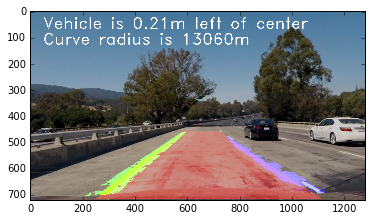

In [21]:
img_test( path_test + test_image_1 )

In [22]:
saveTestWarp( path_test + test_image_1, path_test_output + test_image_1 )

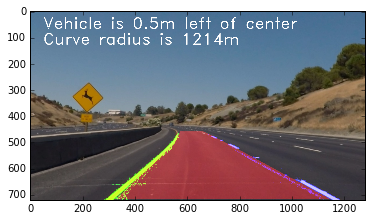

In [23]:
img_test( path_test + test_image_2 )

In [24]:
saveTestWarp( path_test + test_image_2, path_test_output + test_image_2 )

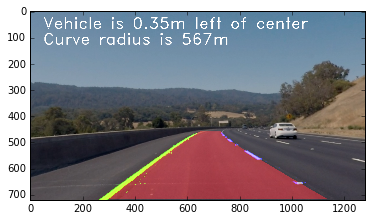

In [25]:
img_test( path_test + test_image_3 )

In [26]:
saveTestWarp( path_test + test_image_3, path_test_output + test_image_3 )

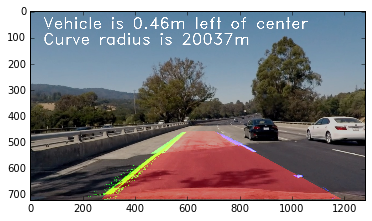

In [27]:
img_test( path_test + test_image_4 )

In [28]:
saveTestWarp( path_test + test_image_4, path_test_output + test_image_4 )

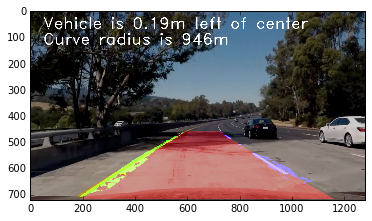

In [29]:
img_test( path_test + test_image_5 )

In [30]:
saveTestWarp( path_test + test_image_5, path_test_output + test_image_5 )

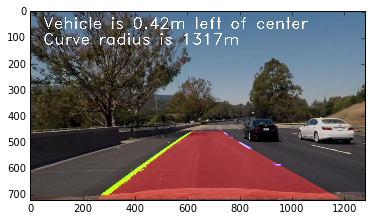

In [31]:
img_test( path_test + test_image_6 )

In [32]:
saveTestWarp( path_test + test_image_6, path_test_output + test_image_6 )

In [33]:
#import stop4test

## Run pipeline on video

In [34]:
# Step 10: Create new window for running/showing (?) video

In [35]:
# Open OpenCV window
cv2.startWindowThread()
cv2.namedWindow('1')
cv2.moveWindow('1', 0, 0)

In [36]:
# Step 11: load video "project_video.mp4"

In [37]:
stream = cv2.VideoCapture( path_folder_projectvideo )

In [38]:
# Step 12: Run pipeline on each video stream frame

In [39]:
while stream.isOpened():
    ret, image = stream.read()
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output = getImageWithProjectionAndText(image)
        reout = cv2.resize(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), (640, 360))
        cv2.imshow('pipe', reout)
    else:
        break
    k = cv2.waitKey(25) & 0xff
    if k == 22 :
        break

In [40]:
# Step 13: Close openCV window

In [41]:
stream.release()
cv2.destroyAllWindows()

In [42]:
# Step 14: Project lane lines onto project_video.mp4 and store as defined in path variable

In [43]:
video = VideoFileClip( path_folder_projectvideo ).fl_image(getImageWithProjectionAndText)

In [44]:
video.write_videofile( path_folder_projectvideo_res, audio=False )

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:17<00:00,  6.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



In [45]:
# Step 15: Show video 

In [46]:
HTML( """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format( path_folder_projectvideo_res ) )


## Done.